### Hyperparameter Tuning of Logistic Regression

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the preprocessed dataset
dataset = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' and 'mental_health_issue' columns exist
if 'cleaned_text' not in dataset.columns or 'mental_health_issue' not in dataset.columns:
    raise ValueError("The dataset must have 'cleaned_text' and 'mental_health_issue' columns.")

# Remove rows with missing values in 'cleaned_text' column
dataset.dropna(subset=['cleaned_text'], inplace=True)

# Initialize the CountVectorizer and fit/transform the cleaned text
HPLRvectorizer = CountVectorizer()
X = HPLRvectorizer.fit_transform(dataset['cleaned_text'])

# Prepare the target variable
y = dataset['mental_health_issue']

# Split the dataset into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
HPLRmodel = LogisticRegression(max_iter=200)

# Define the hyperparameter grid for Randomized Search
param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],       # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization types
    'solver': ['liblinear', 'saga']             # Solvers that support l1, elasticnet
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=HPLRmodel, param_distributions=param_distributions,
                                   n_iter=10, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters from Random Search
print("Best Hyperparameters:", random_search.best_params_)

# Best model from Random Search
best_modelLR = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_modelLR.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1203, in fit
    raise ValueError("l1_ra

Best Hyperparameters: {'solver': 'saga', 'penalty': 'l2', 'C': 100}
Accuracy: 87.42%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.81      0.75      0.78       379
     bipolar       0.84      0.51      0.63       384
  depression       0.74      0.82      0.78       373
      normal       0.91      0.99      0.95      2183
        ptsd       0.86      0.77      0.81       394

    accuracy                           0.87      3713
   macro avg       0.83      0.77      0.79      3713
weighted avg       0.87      0.87      0.87      3713



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


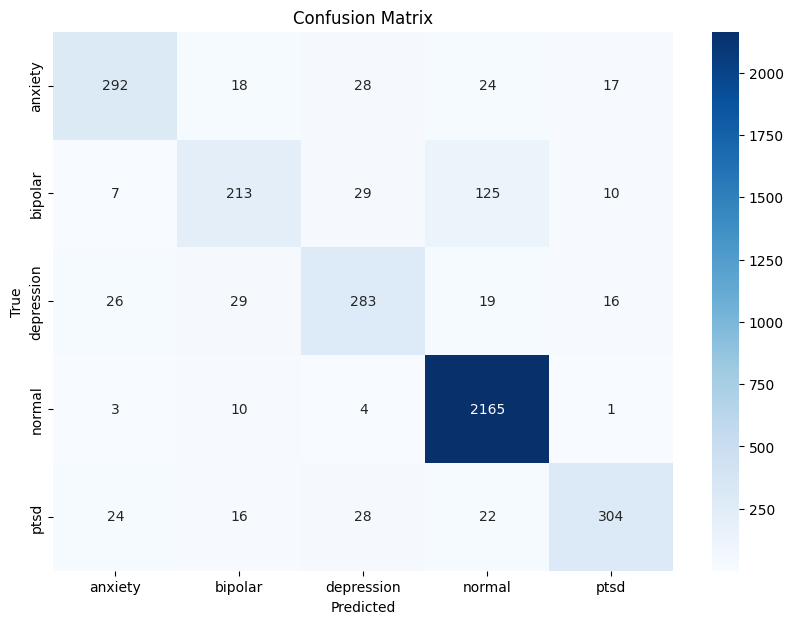

In [ ]:
# Confusion Matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_modelLR.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_modelLR.classes_, yticklabels=best_modelLR.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


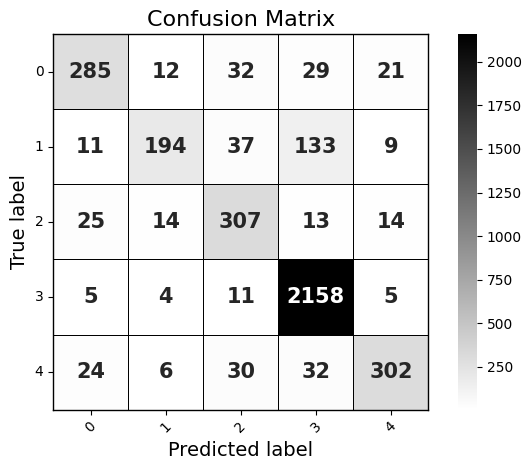

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_modelLR.classes_)

# Plot the confusion matrix
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':15, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


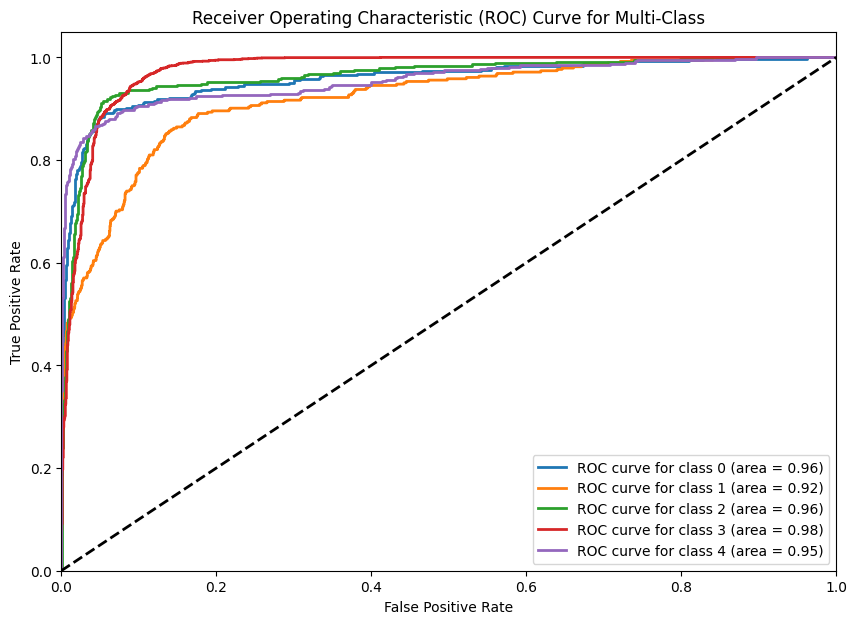

In [3]:
# ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=best_modelLR.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Iterate through each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_modelLR.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()


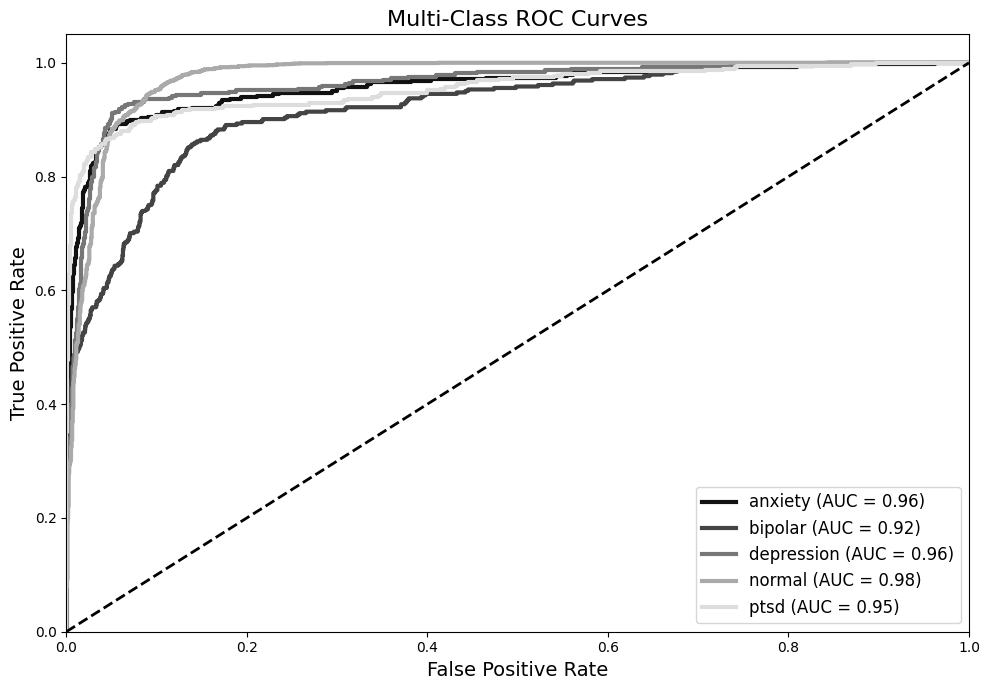

In [5]:
# ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----- ROC CURVES (multi-class) -----
# 1) binarize the true labels
y_test_bin = label_binarize(y_test, classes=best_modelLR.classes_)
n_classes = y_test_bin.shape[1]

# 2) compute fpr, tpr, roc_auc per class
fpr = {}
tpr = {}
roc_auc = {}

# Get predicted probabilities
y_proba = best_modelLR.predict_proba(X_test) # This line is added to get predicted probabilities

for i, lbl in enumerate(best_modelLR.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) plot
plt.figure(figsize=(10, 7))

# choose a few distinct grey-scale shades
greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
# if you have more than 5 classes, you can interpolate or repeat shades

for i, shade in zip(range(n_classes), greys):
    plt.plot(
        fpr[i],
        tpr[i],
        color=shade,
        lw=3,            # extra-thick
        label=f"{best_modelLR.classes_[i]} (AUC = {roc_auc[i]:0.2f})"
    )

# diagonal chance line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Saving the LRmodel and LRvectorizer

import joblib

# Save the best model and vectorizer
joblib.dump(best_modelLR, 'HPTLRmodel.pkl')
joblib.dump(HPLRvectorizer, 'HPTLRvectorizer.pkl')

['HPTLRvectorizer.pkl']

### Hyperparameter Tuning of KNN

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the preprocessed dataset
dataset = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' and 'mental_health_issue' columns exist
if 'cleaned_text' not in dataset.columns or 'mental_health_issue' not in dataset.columns:
    raise ValueError("The dataset must have 'cleaned_text' and 'mental_health_issue' columns.")

# Remove rows with missing values in 'cleaned_text' column
dataset.dropna(subset=['cleaned_text'], inplace=True)

# Initialize the CountVectorizer and fit/transform the cleaned text
HPTKNNvectorizer = CountVectorizer()
X = HPTKNNvectorizer.fit_transform(dataset['cleaned_text'])

# Prepare the target variable
y = dataset['mental_health_issue']

# Split the dataset into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Define the hyperparameter grid for Randomized Search
param_distributions = {
    'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 14, 15, 16, 17, 18, 19, 20],
     # Different values for number of neighbors
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],  # Different distance metrics
    'weights': ['uniform', 'distance']  # Weighing options for neighbors
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_distributions,
                                   n_iter=10, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters from Random Search
print("Best Hyperparameters:", random_search.best_params_)

# Best model from Random Search
best_knn = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 239, in fit
    return self._fit(X, 

Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 10, 'metric': 'euclidean'}
Accuracy: 52.55%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.74      0.22      0.34       379
     bipolar       0.17      0.57      0.26       384
  depression       0.47      0.39      0.43       373
      normal       0.74      0.67      0.71      2183
        ptsd       0.83      0.09      0.16       394

    accuracy                           0.53      3713
   macro avg       0.59      0.39      0.38      3713
weighted avg       0.66      0.53      0.54      3713

Confusion Matrix:
 [[  84  121   35  137    2]
 [   2  217   44  119    2]
 [   7  131  147   87    1]
 [   2  699   12 1468    2]
 [  19   95   78  167   35]]


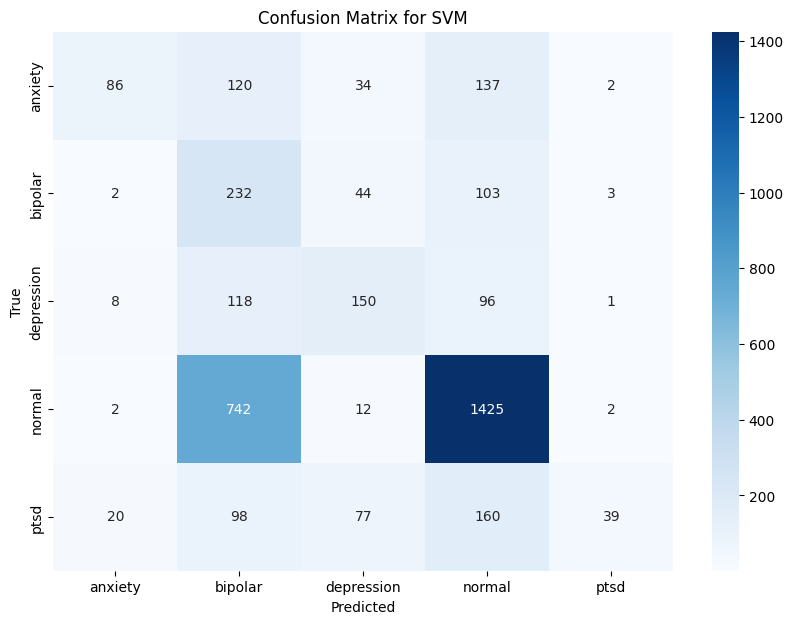

In [ ]:
# Confusion Matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM')
plt.show()


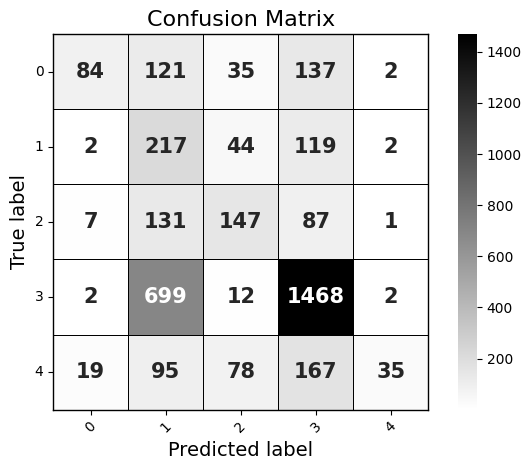

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_knn.classes_)

# Plot the confusion matrix
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':15, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


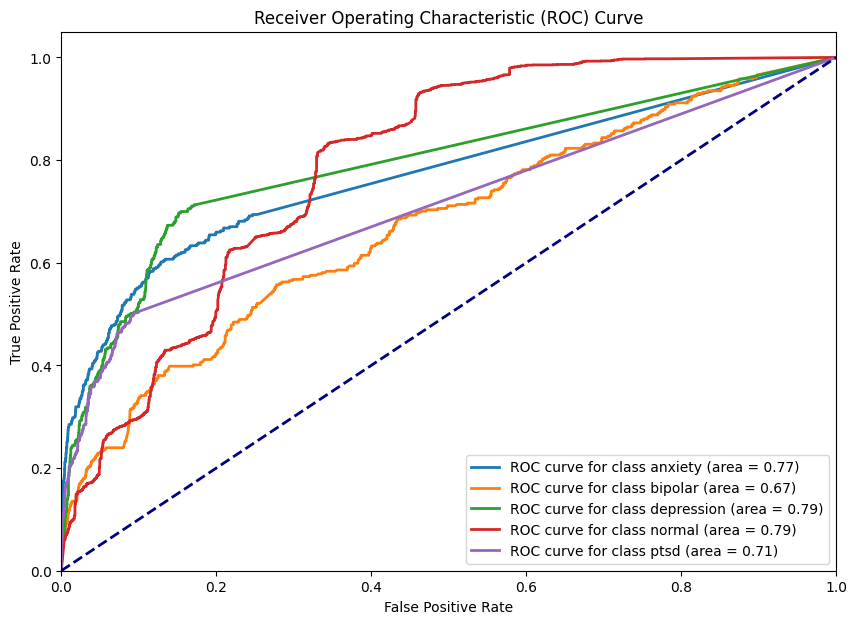

In [ ]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=best_knn.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_knn.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'
             ''.format(best_knn.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


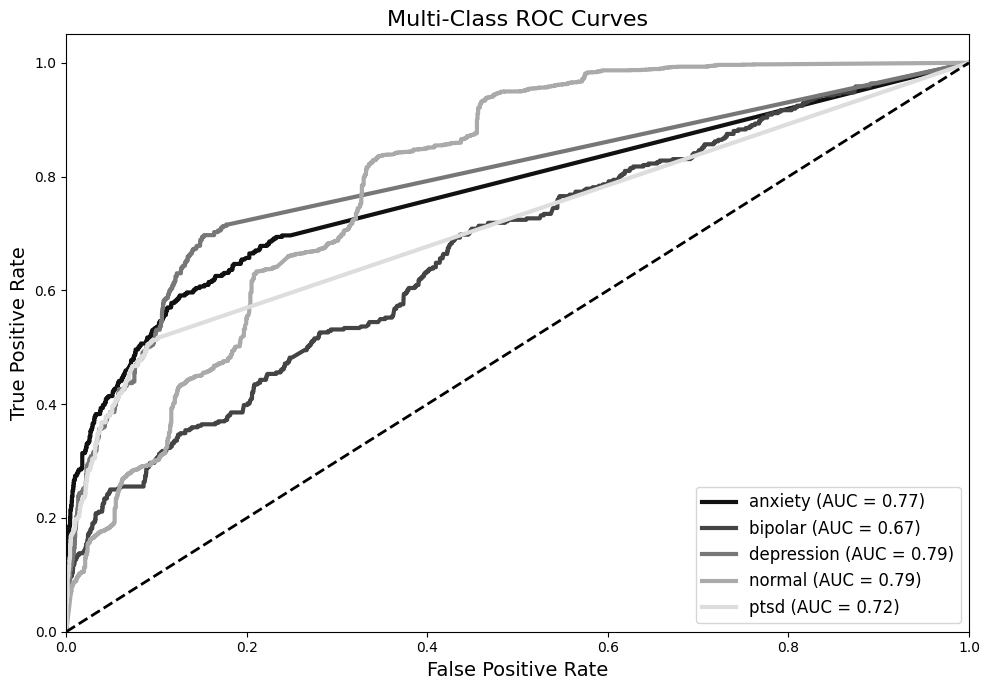

In [8]:
# ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----- ROC CURVES (multi-class) -----
# 1) binarize the true labels
y_test_bin = label_binarize(y_test, classes=best_knn.classes_)
n_classes = y_test_bin.shape[1]

# 2) compute fpr, tpr, roc_auc per class
fpr = {}
tpr = {}
roc_auc = {}

# Get predicted probabilities
y_proba = best_knn.predict_proba(X_test) # This line is added to get predicted probabilities

for i, lbl in enumerate(best_knn.classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3) plot
plt.figure(figsize=(10, 7))

# choose a few distinct grey-scale shades
greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']
# if you have more than 5 classes, you can interpolate or repeat shades

for i, shade in zip(range(n_classes), greys):
    plt.plot(
        fpr[i],
        tpr[i],
        color=shade,
        lw=3,            # extra-thick
        label=f"{best_knn.classes_[i]} (AUC = {roc_auc[i]:0.2f})"
    )

# diagonal chance line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Multi-Class ROC Curves', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning of SVM

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Load the preprocessed dataset
dataset = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' and 'mental_health_issue' columns exist
if 'cleaned_text' not in dataset.columns or 'mental_health_issue' not in dataset.columns:
    raise ValueError("The dataset must have 'cleaned_text' and 'mental_health_issue' columns.")

# Remove rows with missing values in 'cleaned_text' column
dataset.dropna(subset=['cleaned_text'], inplace=True)

# Initialize the CountVectorizer and fit/transform the cleaned text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset['cleaned_text'])

# Prepare the target variable
y = dataset['mental_health_issue']

# Split the dataset into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVC model
model = SVC()

# Define the hyperparameter grid for Randomized Search
param_distributions = {
    'C': [0.1, 1, 10, 100],               # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto', 0.1, 1],   # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                   n_iter=10, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters from Random Search
print("Best Hyperparameters:", random_search.best_params_)

# Best model from Random Search
best_model = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Hyperparameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 1}
Accuracy: 85.13%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.72      0.76      0.74       379
     bipolar       0.62      0.61      0.61       384
  depression       0.74      0.71      0.72       373
      normal       0.94      0.95      0.95      2183
        ptsd       0.78      0.74      0.76       394

    accuracy                           0.85      3713
   macro avg       0.76      0.75      0.76      3713
weighted avg       0.85      0.85      0.85      3713



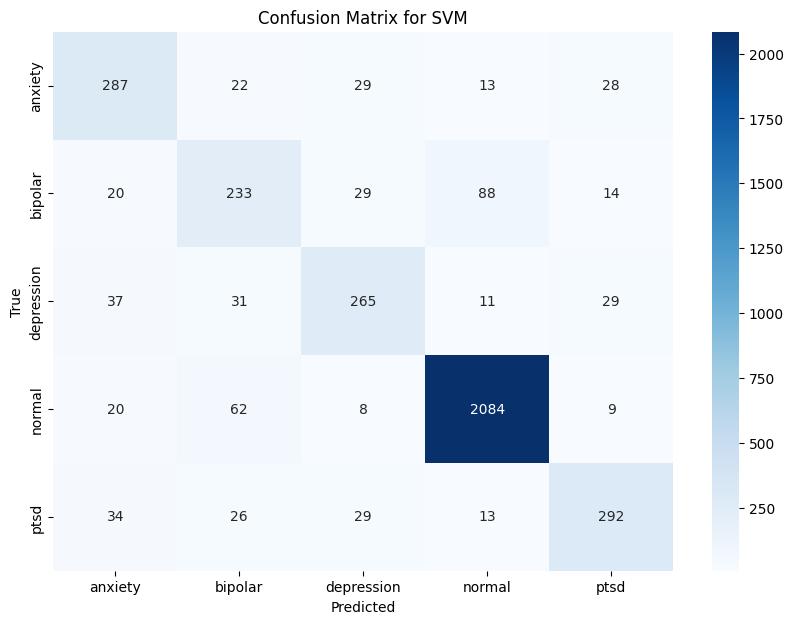

In [ ]:
# Confusion Matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for SVM')
plt.show()


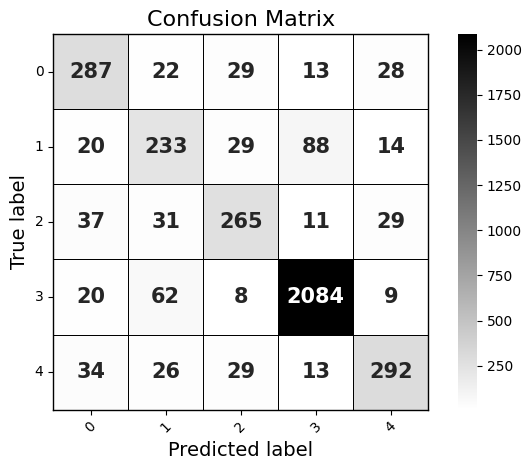

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Plot the confusion matrix
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':15, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


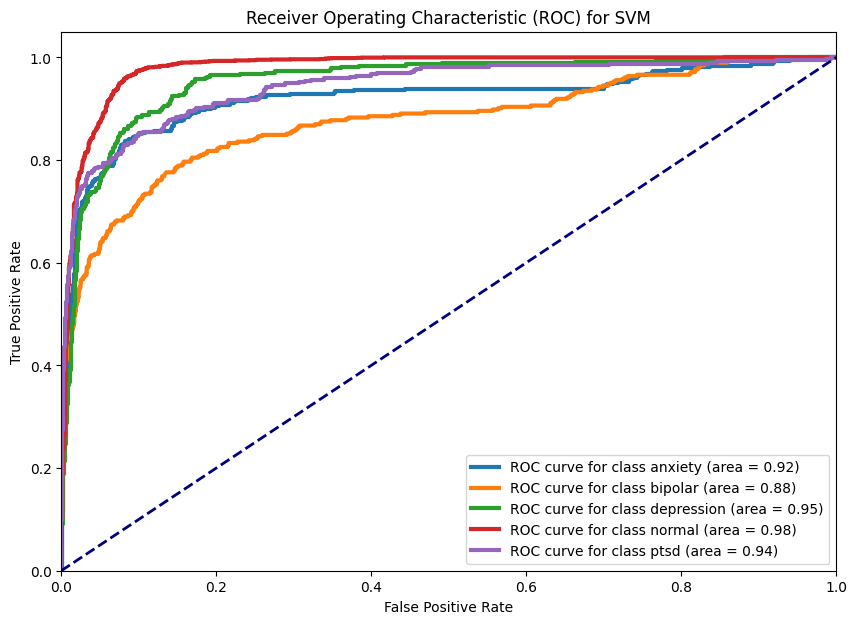

In [14]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_model.decision_function(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=3, label='ROC curve for class {} (area = {:.2f})'.format(best_model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for SVM')
plt.legend(loc="lower right")
plt.show()


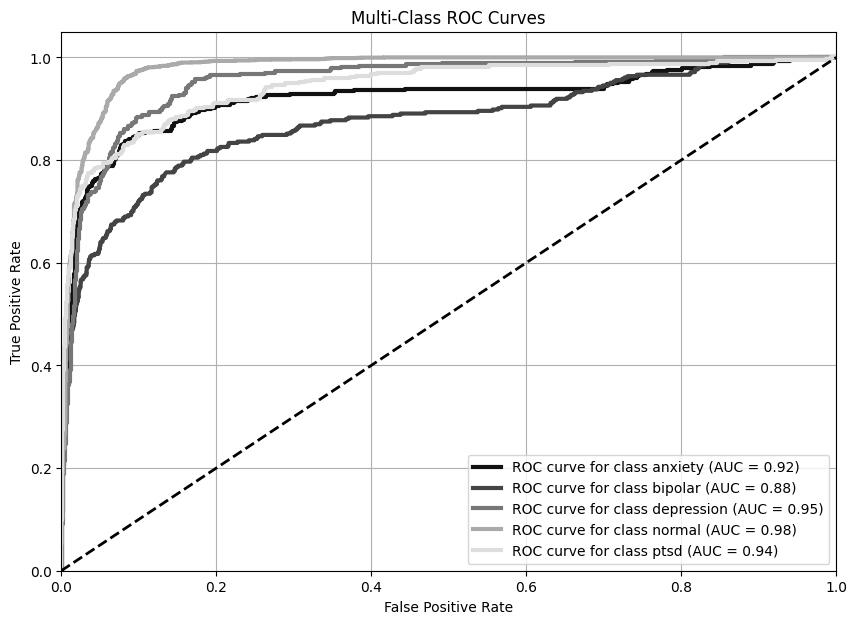

In [16]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define grey shades with good contrast
greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_model.decision_function(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    color = greys[i % len(greys)]  # Cycle through grey shades
    plt.plot(fpr[i], tpr[i], color=color, lw=3, linestyle='-',
             label=f'ROC curve for class {best_model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Random guessing line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Hyperparameter Tuning of Naive Bayes

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import uniform

# Load the preprocessed dataset
dataset = pd.read_csv('preprocessed_mental_health.csv')

# Check if 'cleaned_text' and 'mental_health_issue' columns exist
if 'cleaned_text' not in dataset.columns or 'mental_health_issue' not in dataset.columns:
    raise ValueError("The dataset must have 'cleaned_text' and 'mental_health_issue' columns.")

# Remove rows with missing values in 'cleaned_text' column
dataset.dropna(subset=['cleaned_text'], inplace=True)

# Initialize the CountVectorizer and fit/transform the cleaned text
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(dataset['cleaned_text'])

# Prepare the target variable
y = dataset['mental_health_issue']

# Split the dataset into Training and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Naive Bayes model
naive_bayes_model = MultinomialNB()

# Define the parameter distribution for Randomized Search
param_distributions = {
    'alpha': uniform(0.001, 5.0)  # Sampling alpha from a uniform distribution
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=naive_bayes_model, param_distributions=param_distributions,
                                   n_iter=10, scoring='accuracy', cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best hyperparameters from Random Search
print("Best Hyperparameters:", random_search.best_params_)

# Best model from Random Search
best_model = random_search.best_estimator_

# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Best Hyperparameters: {'alpha': np.float64(0.2914180608409973)}
Accuracy: 83.95%
Classification Report:
               precision    recall  f1-score   support

     anxiety       0.69      0.76      0.72       379
     bipolar       0.75      0.55      0.64       384
  depression       0.60      0.83      0.70       373
      normal       0.96      0.91      0.94      2183
        ptsd       0.73      0.79      0.76       394

    accuracy                           0.84      3713
   macro avg       0.75      0.77      0.75      3713
weighted avg       0.85      0.84      0.84      3713

Confusion Matrix:
 [[ 287   12   54    3   23]
 [  26  213   45   73   27]
 [  28   17  311    0   17]
 [  46   29   68 1993   47]
 [  29   12   37    3  313]]


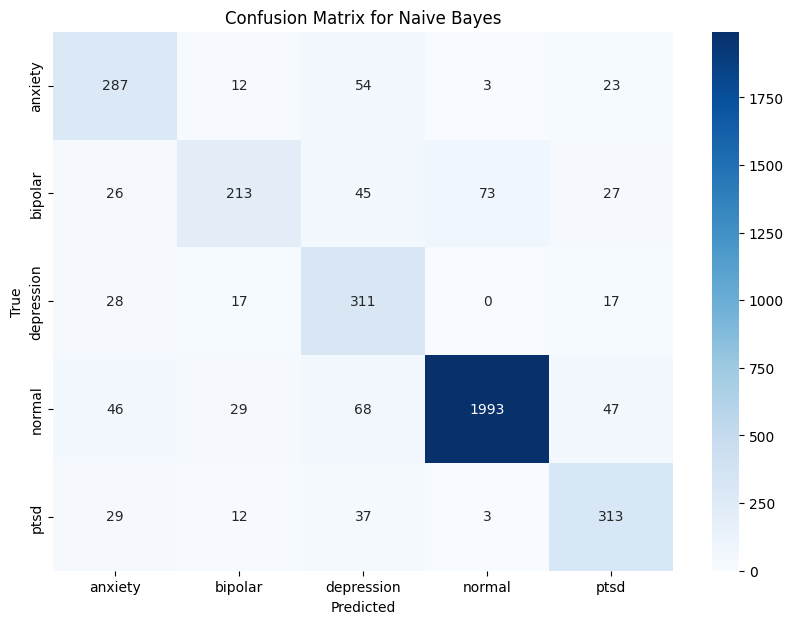

In [ ]:
# Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()


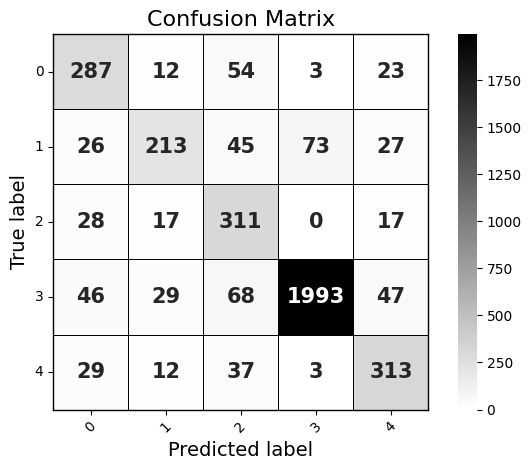

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='gist_yarg',         # grayscale colormap with deep tones ( gist_yarg )
    cbar=True,                # color bar for value reference
    cbar_kws={'label': ''},
    annot_kws={'size':15, 'weight':'bold'},
    linewidths=0.5,           # thinner borders
    linecolor='black',
    square=True
)

# Fix bottom and right border visibility
ax.set_frame_on(True)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


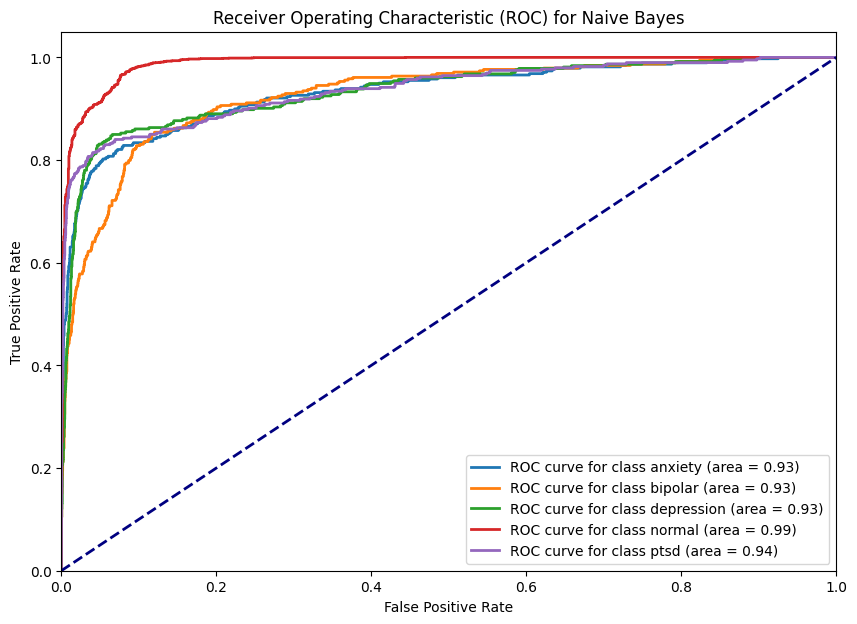

In [ ]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for class {0} (area = {1:0.2f})'.format(best_model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Naive Bayes')
plt.legend(loc="lower right")
plt.show()


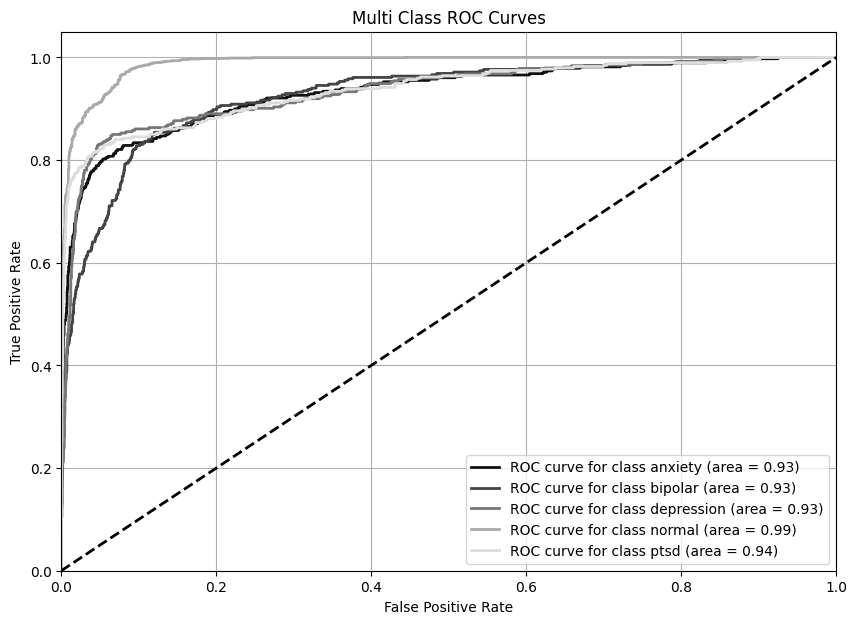

In [22]:
# ROC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define grey shades
greys = ['#111111', '#444444', '#777777', '#AAAAAA', '#DDDDDD']

# Binarize the output for ROC
y_test_binarized = label_binarize(y_test, classes=best_model.classes_)
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    color = greys[i % len(greys)]  # Cycle through grey shades
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve for class {0} (area = {1:0.2f})'.format(best_model.classes_[i], roc_auc[i]))

# Random guessing line
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')

# Plot formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
